In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd


Loading data.

The biggest challenge in this task was to match different partitions, so we're
separating them on two datasets (one is with NaNs, other - without, hence the name "nanlabeling", other variables regarding Brainnettome and Schaefer200 are also called an_smth and nan_smth, respectively)

In [4]:
data = np.load('ihb.npy')

model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=20)
)

a = np.prod(1-np.isnan(data), axis = (1))

nanlabeling = np.prod(a, axis = -1)
print(nanlabeling)

[1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0
 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0
 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0
 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0
 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1
 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0
 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1
 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1]


Then we use PCA to make features indenpendent (and it's done by concatinating all patients measuremts into one big "measurement". This way, correlation of features preserves). Also, because this is practically the same two datasets, just with different features, this would hopefully make them fit between each other (if we model that there is a unitary transformaton from one to another, PCA would extract the same features)

After extraxting PCA features, we use them to create brain connectivity maps.

In [7]:
from sklearn.decomposition import PCA

nan_indexes = np.nonzero(1-nanlabeling)[0]
an_indexes = np.nonzero(nanlabeling)[0]

nan_data = data[nan_indexes, :, :200]
an_data = data[an_indexes, :, :]

pca = PCA(n_components=200)
pca_nan_data = pca.fit_transform(nan_data.reshape((1600, 200)))
pca_an_data = pca.fit_transform(an_data.reshape((1600, 246)))

def connectivity(vector_data):
  connectivity_map = np.einsum('k i, k j -> i j', vector_data, vector_data)
  modules = np.sqrt(np.einsum('k i, k i -> i', vector_data, vector_data))
  matrix_modules = modules[:, None] @ modules[None, :]
  connectivity_map = connectivity_map/matrix_modules
  return connectivity_map

nan_connect_pca = np.zeros((160, 200, 200))
an_connect_pca = np.zeros((160, 200, 200))

for i in range(160):
  nan_connect_pca[i, :, :] = connectivity(pca_nan_data.reshape((160, 10, 200))[i, :, :])
  an_connect_pca[i, :, :] = connectivity(pca_an_data.reshape((160, 10, 200))[i, :, :])


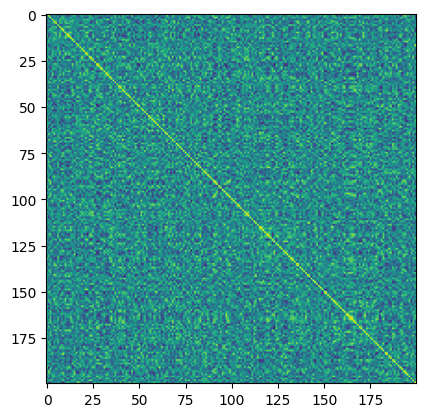

In [9]:
import matplotlib.pyplot as plt
connect_pca = np.zeros((320, 200*200))
connect_pca[nan_indexes] = nan_connect_pca.reshape((160, 200**2))
connect_pca[an_indexes] = an_connect_pca.reshape((160, 200**2))
plt.imshow(connect_pca[0].reshape((200,200)))


compute dot product between for pair of connectivity maps

In [16]:
dot_product_matrix = np.einsum('i k, j k -> i j', connect_pca, connect_pca)

In [13]:
pip install pyvis

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [24]:
import pandas as pd
from pyvis.network import Network



net = Network(notebook = True, cdn_resources = "remote",
                bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%",
)
nodes = list(range(320))
edges = []
for i in range(320):
  for j in range(i+1, 320):
    if dot_product_matrix[i, j]>1400:
        edges.append([i, j])

net.add_nodes(nodes, color = ['#ff0000' if i else  '#00ff00' for i in nanlabeling])
net.add_edges(edges)
net.save_graph("connectivity.html")

This is graph of all points where edge is drawn if dot product reaches a treshold. Red dots are a Brainnetome, green dots are Shaeffer200.
Here we can see that connectivity maps come in pairs. My guess is that this is same scans with two different smoothing strategies, they would be most simillar.

In [25]:
from IPython.display import display, HTML

# Read the contents of the HTML file
with open('connectivity.html', 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))

Then we treat each pair as the same dot. Similarity metric for each pair is maximum of two sums of dot products (for two ways two pairs can correspond to each other).

In [27]:
pairs = np.array(edges)

pairs_simillarity = np.zeros((160, 160))
for i in range(160):
  for j in range(160):
    if nanlabeling[pairs[i, 0]] == nanlabeling[pairs[j, 0]]:
      pairs_simillarity[i, j] = max([dot_product_matrix[pairs[i][0], pairs[j][0]]+dot_product_matrix[pairs[i][1], pairs[j][1]],
                                dot_product_matrix[pairs[i][1], pairs[j][0]]+dot_product_matrix[pairs[i][0], pairs[j][1]]])


Then, we clusterise pairs into groups of four pairs. (Each cluster has only one color)

In [28]:
import pandas as pd
from pyvis.network import Network



net = Network(notebook = True, cdn_resources = "remote",
                bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%",
)



nodes = list(np.arange(160))
print(nodes)
edges = []
for i in range(160):
  for j in range(i+1, 160):
    if nanlabeling[pairs[i][0]]==nanlabeling[pairs[j][0]] and nanlabeling[pairs[i][0]]==1:
      if pairs_simillarity[i, j]>500:
        edges.append([i, j])
    elif nanlabeling[pairs[i][0]]==nanlabeling[pairs[j][0]] and nanlabeling[pairs[i][0]]==0:
      if pairs_simillarity[i, j]>470:
        edges.append([i, j])

net.add_nodes(nodes, color = ['#ff0000' if i else  '#00ff00' for i in nanlabeling[pairs[:, 0]]])
net.add_edges(edges)
net.save_graph("pairs.html")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]


In [29]:
from IPython.display import display, HTML

# Read the contents of the HTML file
with open('pairs.html', 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))

For red dots, there are no one treshold that will clusterise them into groups of four, so for them clustering is done partially manually: I deleted all groups of four, then lowered the treshold untill I have some groups of four again, then repeat this untill all dots are in some cluster.

But for green ones it can be done automatically using adjecency matrix. If you can reach one dot from another for three steps, that means they are in the same cluster, and adjecency matrix to the n'th power shows how many ways there are from i'th point to the j'th point.

In [44]:
adjacency_matrix = np.zeros((160, 160))
green_edges = list(filter(lambda x: nanlabeling[pairs[x[0]][0]]==0,edges))
for i in green_edges:
  adjacency_matrix[i[0], i[1]] = 1
  adjacency_matrix[i[1], i[0]] = 1

adjacency_matrix1 = np.logical_or(np.logical_or(adjacency_matrix , (adjacency_matrix @ adjacency_matrix)) ,  (adjacency_matrix @ adjacency_matrix @ adjacency_matrix))
neighbours = []
for i in range(160):
  neighbours.append(np.nonzero(adjacency_matrix1[i, :])[0])
a = {tuple()}
neighbours = list(set([tuple(np.sort(i)) for i in neighbours])-a)
neighbours1 = list(filter(lambda x: len(x)==4, neighbours))

In [45]:
neighbours1

[(14, 81, 121, 153),
 (72, 142, 147, 158),
 (27, 44, 113, 144),
 (7, 15, 54, 89),
 (97, 100, 132, 148),
 (64, 79, 91, 119),
 (25, 66, 86, 107),
 (1, 36, 52, 69),
 (9, 41, 93, 127),
 (8, 31, 37, 55),
 (38, 56, 82, 110),
 (24, 75, 118, 155),
 (12, 17, 21, 63),
 (48, 59, 77, 117),
 (61, 85, 96, 143),
 (16, 67, 104, 120),
 (42, 50, 51, 84),
 (34, 88, 135, 140),
 (4, 28, 109, 136),
 (80, 92, 112, 150)]

In [46]:
nan_quads = np.array(neighbours1)
an_quads = np.array([(2, 45, 129, 141),
 (19, 90, 123, 157),
 (32, 53, 83, 94),
 (73, 87, 106, 130),
 (10, 23, 39, 68),
 (13, 99, 103, 131),
 (58, 74, 98, 126),
 (60, 78, 102, 134),
 (71, 111, 115, 124),
 (22, 30, 40, 122),
 (20, 65, 101, 152),
 (43, 125, 128, 145),
 (6, 46, 105, 151),
 (33, 76, 146, 154),
 (29, 70, 108, 133),
  (0, 47, 49, 116),
 (5, 18, 57, 114),
 (35, 95, 137, 149),
 (62, 138, 139, 156),
 (3, 11, 26, 159)])

In [47]:
naneights = pairs[np.array(nan_quads)].reshape((20, 8))
aneights =  pairs[np.array(an_quads)].reshape((20, 8))

Now we have 40 clusters of eight, 20 for each brain partition. Now we have to match them between each other.

If two clusters of eight correspond to same patient, then there is one-to-one correspondence for each scan in Brainnetome partitioning there is that same scan in Shaefer200 partitioning. There is 8! possible correspondances, so I look throw all of them and search for the least total pairwise distance.

In [31]:
distance_matrix = np.zeros((320,320))
for i in range(320):
  for j in range(320):
    distance_matrix[i, j] = np.sum((connect_pca[i, :]-connect_pca[j, :])**2)

In [32]:
from sympy.utilities.iterables import multiset_permutations

def distance_between_eights(eight1, eight2):
  order = np.arange(8)
  sums = np.zeros((40320))
  for idx, p in enumerate(multiset_permutations(order)):
    sums[idx] = np.sum(distance_matrix[eight1, eight2[p]])
  return np.min(sums)

In [49]:
cluster_distances = np.zeros((20, 20)) #this one takes a while, about two minutes
for i in range(20):
  print(i)
  for j in range(20):
    cluster_distances[i, j] = distance_between_eights(aneights[i], naneights[j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Then I use greedy method to make cluster correspondence. I choose pair with the least distance between them, add them to cluster pairs, then remove them from search, and repeat untill I exaust all clusters.

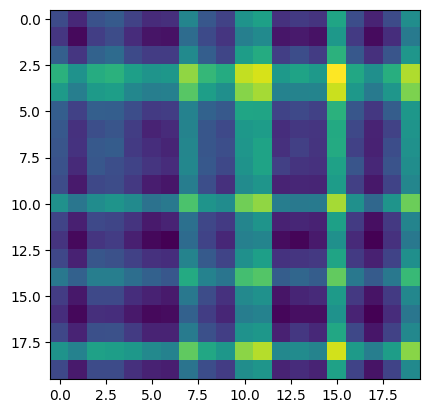

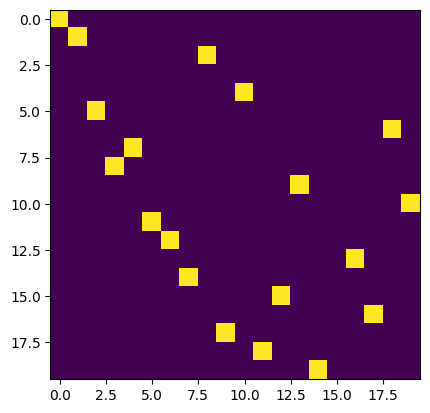

In [50]:
plt.imshow(cluster_distances)
plt.show()
cluster_pairs = []
remains = cluster_distances.copy()
for i in range(20):
  mx = np.unravel_index(np.argmin(remains, axis=None), remains.shape)
  cluster_pairs.append(mx)
  remains[mx[0], :] = np.max(cluster_distances)
  remains[:, mx[1]] = np.max(cluster_distances)
an_max = np.zeros((20,20))

for x in cluster_pairs:
  an_max[x] = 1

plt.imshow(an_max)
plt.show()

And here is the final labeling.

In [51]:
labeling = np.zeros((320))
for i in range(20):
  labeling[aneights[cluster_pairs[i][0]]] = i
  labeling[naneights[cluster_pairs[i][1]]] = i

In [52]:
pd.DataFrame({'prediction': labeling}).to_csv('labeling.csv', index=False)

In [53]:
with open('final_labeling.csv') as file:
     final_labeling = file.readlines()
final_labeling = [int(float(i[:-1]))for i in final_labeling[1:]]
final_labeling = np.array(final_labeling)

In [54]:
from sklearn.metrics import rand_score as ri
ri(labeling, final_labeling)

0.9949843260188088